# Protein detection using Graph Convolution Networks (GCN)

In this project, the goal is to develop a Convolutional Graph Network (CGN) capable of classifying graphs as either representing proteins or not. The dataset utilized is specific to proteins and is structured using the torch_geometric library, which is well-suited for handling graph-based data. Each graph in the dataset is a representation of a protein, with nodes and edges corresponding to distinct features. The CGN model is designed to learn intricate patterns within these graphs, leveraging graph convolutional layers, pooling, and fully connected layers to discern the unique characteristics indicative of proteins. Through a process of training, validation, and testing, the aim is to fine-tune the model's parameters, optimizing its ability to accurately classify protein graphs. The success of the project hinges on achieving a robust and effective model that can generalize well to unseen protein data, contributing to the broader field of computational biology and molecular research.

## 1. GCN implementation :

In [1]:
#main import function and library
import networkx as nx
import torch_geometric as tg
import numpy as np
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch.nn import Linear, Parameter, Dropout
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.utils import add_self_loops, degree
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import f1_score, precision_recall_fscore_support, recall_score, precision_score, roc_auc_score, roc_curve, accuracy_score
from IPython.core.display import deepcopy
import matplotlib.pyplot as plt

### Split the dataset into train, val and test datasets

In [2]:
dataset = tg.datasets.TUDataset(root='/tmp/PROTEINS', name='PROTEINS', use_node_attr=True)
dataset = dataset.shuffle()
train_dataset = dataset[:800]
val_dataset = dataset[800:956]
test_dataset = dataset[956:]

print('Number of training graphs: ',len(train_dataset))
print('Number of validation graphs: ',len(test_dataset))
print('Number of test graphs: ',len(test_dataset))

proportion = torch.bincount(dataset.y)/len(dataset.y)
print(f"Positive class ratio : {proportion[1]:.2f}")
print(f"Negative class ratio : {proportion[0]:.2f}")

Number of training graphs:  800
Number of validation graphs:  157
Number of test graphs:  157
Positive class ratio : 0.40
Negative class ratio : 0.60


### Split each dataset into batchs

In [3]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Graph example

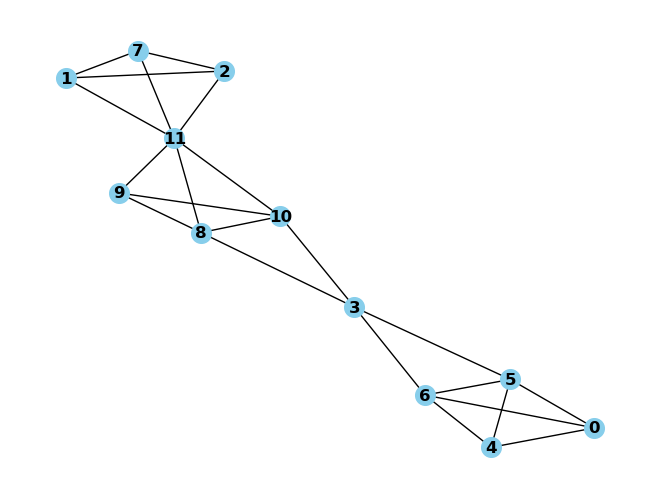

In [61]:
for batch in train_loader:
    edges = []
    for i in range(len(batch.edge_index[0])):
        if batch.batch[batch.edge_index[0][i].item()] == 0:
            if (batch.edge_index[0][i].item(), batch.edge_index[1][i].item()) not in edges:
                edges.append((batch.edge_index[0][i].item(), batch.edge_index[1][i].item()))
    # Créer un graphe dirigé à partir des arêtes
    G = nx.Graph()
    G.add_edges_from(edges)
    # Dessiner le graphe
    nx.draw(G, batch.pos, with_labels=True, font_weight='bold', node_size=200, node_color='skyblue', font_color='black', arrowsize=20)
    break

### GCN

In [21]:
def score_fn(model, loader, threshold = 0.5):
    predicted_labels = []
    true_labels = []
    predicted_scores = []

    with torch.no_grad():
        for b in loader:
            out = model(b)
            predicted_score = out.squeeze()
            true_labels_batch = b.y
            predicted_labels_batch = (predicted_score >= threshold).float()

            predicted_labels.append(predicted_labels_batch)
            predicted_scores.append(predicted_score)
            true_labels.append(true_labels_batch)

    # Concaténez les listes de batchs en tensors 1D
    predicted_labels = torch.cat(predicted_labels)
    predicted_scores = torch.cat(predicted_scores)
    true_labels = torch.cat(true_labels)

    # Convertissez les tensors en tableaux NumPy
    predicted_labels = predicted_labels.numpy()
    predicted_scores = predicted_scores.numpy()
    true_labels = true_labels.numpy()

    acc = accuracy_score(true_labels, predicted_labels)

    return acc

In [ ]:
#GCN model with pytorch geometric
class GCN(torch.nn.Module):
    def __init__(self, feature_size, hidden_size1, hidden_size2,nb_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(feature_size, hidden_size1)
        #self.conv1 = L3_conv(feature_size,8)
        self.conv2 = GCNConv(hidden_size1, hidden_size2)
        self.conv3 = GCNConv(hidden_size2, nb_classes)
        self.dropout = nn.Dropout(0.4)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = self.dropout(x)

        # readout
        x = global_mean_pool(x, batch)

        x = F.sigmoid(x)
        return x
    
    def train_model(self, train_loader, val_loader, optimizer, epochs=1000, patience=200):
        train_losses = []
        val_scores = []
        best_score = 0
        no_improvment = 0

        for epoch in range(epochs):
            self.train()
            sum_train_loss = 0
            for train_batch in train_loader:
                optimizer.zero_grad()
                out = self(train_batch)
                train_loss = F.cross_entropy(out.squeeze(), train_batch.y.float())
                sum_train_loss += train_loss
                train_loss.backward()
                optimizer.step()

            self.eval()
            #score = self.eval_model(self,val_loader)
            score = score_fn(self,val_loader)
            train_losses.append(sum_train_loss.detach().float())
            val_scores.append(score)
            
            if score > best_score:
                best_score = score
                best_model = deepcopy(self)
                no_improvment = 0
            else:
                no_improvment += 1

            if no_improvment == patience:
                print("Early stopping ...")
                break

            if no_improvment == 0:
                print(f"[{epoch+1}] Accuracy: {score:.2f} | Loss: {sum_train_loss:.2f}*")
            else:
                print(f"[{epoch+1}] Accuracy: {score:.2f} | Loss: {sum_train_loss:.2f}")
                
        print("\n Final Score:")
        
        final_score = score_fn(best_model,val_loader)#,threshold=best_score[4])
        print(final_score)
        plt.plot(train_losses)
        plt.figure()
        plt.plot(val_scores, label = 'Accuracy')
        plt.legend()
        
        return best_model
    
    def eval_model(self, model, loader, threshold = 0.5):
        predicted_labels = []
        true_labels = []
        predicted_scores = []

        with torch.no_grad():
            for b in loader:
                out = self(b)
                predicted_score = out.squeeze()
                true_labels_batch = b.y
                predicted_labels_batch = (predicted_score >= threshold).float()

                predicted_labels.append(predicted_labels_batch)
                predicted_scores.append(predicted_score)
                true_labels.append(true_labels_batch)

        # Concaténez les listes de batchs en tensors 1D
        predicted_labels = torch.cat(predicted_labels)
        predicted_scores = torch.cat(predicted_scores)
        true_labels = torch.cat(true_labels)
        
        # Convertissez les tensors en tableaux NumPy
        predicted_labels = predicted_labels.numpy()
        predicted_scores = predicted_scores.numpy()
        true_labels = true_labels.numpy()

        acc = accuracy_score(true_labels, predicted_labels)

        return acc

### Training

[1] Accuracy: 0.63 | Loss: 916.83*
[2] Accuracy: 0.63 | Loss: 916.13
[3] Accuracy: 0.63 | Loss: 915.04
[4] Accuracy: 0.63 | Loss: 914.39
[5] Accuracy: 0.63 | Loss: 913.66
[6] Accuracy: 0.63 | Loss: 914.16
[7] Accuracy: 0.63 | Loss: 913.37
[8] Accuracy: 0.63 | Loss: 913.52
[9] Accuracy: 0.63 | Loss: 911.19*
[10] Accuracy: 0.63 | Loss: 908.44
[11] Accuracy: 0.63 | Loss: 911.17
[12] Accuracy: 0.62 | Loss: 908.35
[13] Accuracy: 0.63 | Loss: 908.31
[14] Accuracy: 0.63 | Loss: 906.62
[15] Accuracy: 0.63 | Loss: 906.94
[16] Accuracy: 0.64 | Loss: 906.60*
[17] Accuracy: 0.65 | Loss: 907.24*
[18] Accuracy: 0.65 | Loss: 903.63
[19] Accuracy: 0.65 | Loss: 903.65
[20] Accuracy: 0.64 | Loss: 906.80
[21] Accuracy: 0.68 | Loss: 905.74*
[22] Accuracy: 0.67 | Loss: 903.72
[23] Accuracy: 0.65 | Loss: 905.69
[24] Accuracy: 0.64 | Loss: 903.85
[25] Accuracy: 0.66 | Loss: 904.38
[26] Accuracy: 0.67 | Loss: 899.83
[27] Accuracy: 0.65 | Loss: 906.02
[28] Accuracy: 0.66 | Loss: 903.09
[29] Accuracy: 0.67 | Lo

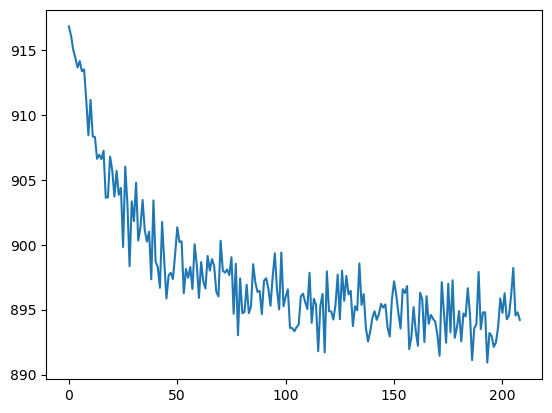

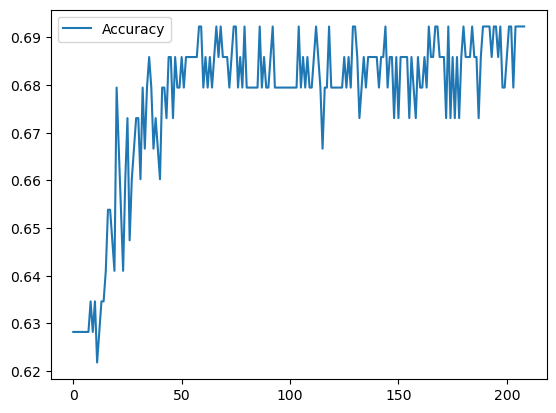

In [68]:
model = GCN(dataset.num_features,16,8,1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

best_model = model.train_model(train_loader, val_loader, optimizer, epochs=1000, patience=150)

In [69]:
test_score = score_fn(model=best_model,loader=test_loader,threshold = 0.5)
print(f"Accuracy: {test_score:.2f}")

Accuracy: 0.63



Graph Convolutional Networks (GCNs) exhibit limitations in expressivity, as they lack the inherent ability to perform certain graph-specific computations. Notably, GCNs struggle with fundamental graph tasks such as counting triangles, a deficiency that can adversely impact their performance in various applications. This inherent limitation could contribute to the observed suboptimal performance of the model in the task at hand. Nevertheless, there are strategies to enhance the expressiveness of GCNs. One approach involves augmenting the graph representation with additional edge features, specifically capturing the number of times an edge participates in triangles or cycles of size 4. This augmentation enables the model to incorporate more nuanced information about the graph's local structure. Additionally, considering alternative Graph Neural Networks (GNNs) such as G2N2, which may possess enhanced expressive power, offers an avenue for improving the model's overall performance on protein graph classification tasks. These adjustments aim to overcome the inherent limitations of GCNs and pave the way for more effective and accurate graph-based learning.